In [249]:
import torchvision.models as models

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pandas as pd
import torch.utils.data.dataset as dataset
import cv2
import re
import matplotlib.patches as patches

In [65]:
##### For all paths
csv_path = "./DL_info.csv"
Image_slices_dir = "/home/parv/Dropbox/Final_Images_2/"

In [17]:
#### Optional, remove it later, put the same into dataset class
df = pd.read_csv(csv_path)          # The DL_info.csv file path
# print(df)
train_df = df[df['Train_Val_Test']==1]
validation_df = df[df['Train_Val_Test']==2]
test_df = df[df['Train_Val_Test']==3]

print(len(train_df.index))
print(len(validation_df.index))
print(len(test_df.index))

print(len(train_df.index)+len(validation_df.index)+len(test_df.index))

22919
4889
4927
32735


In [294]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, sample):
        image, lesions = sample['image'], sample['lesions']
        plt.figure()
        plt.imshow(image)
        for i in range(lesions.shape[0]):
            plt.gca().add_patch(plt.Rectangle((lesions[i][0],lesions[i][1]),
                                lesions[i][2]-lesions[i][0],
                                lesions[i][3]-lesions[i][1],
                                linewidth=1,edgecolor='r', fill=False))
        # plt.scatter(lesions[:, 0], lesions[:, 1], s=10, marker='.', c='r')
        plt.show()
        print(image.shape)
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_h, new_w))
        
        assert new_h==new_w, "Width Size not same"
        # h and w are swapped for lesions because for images,
        # x and y axes are axis 1 and 0 respectively
#         for i in range(0, len(lesions)):
#             lesions[i] = lesions[i]*new_h
        lesions = lesions * [new_w / w, new_h / h, new_w / w, new_h / h]
        plt.figure()
        plt.cla()
        plt.imshow(img)
        for i in range(lesions.shape[0]):
            plt.gca().add_patch(plt.Rectangle((lesions[i][0],lesions[i][1]),
                                lesions[i][2]-lesions[i][0],
                                lesions[i][3]-lesions[i][1],
                                linewidth=1,edgecolor='r', fill=False))
        plt.show()
        print (img.shape)
        print (lesions)
        return {'image': img, 'lesions': lesions}

In [295]:
class ToTensor(object):
    def __call__(self, sample):
        image, lesions = sample['image'], sample['lesions']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'lesions': torch.from_numpy(lesions)}

In [296]:
img_transform = transforms.Compose([
    Rescale(512),
#    transforms.ToTensor(),
])


# dataset_type : 1 for train, 2 for validation, 3 for test
class ImageDataset(dataset.Dataset):
    def __init__ (self, root_dir, dataset_type, csv_file=csv_path, transform=img_transform):
        self.root_dir = root_dir
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)[df['Train_Val_Test']==dataset_type]
        self.imf_transform = img_transform
    def __len__(self):
        return len(self.df.index)
    def __getitem__(self, idx):
        # read file
        file_name = os.path.join(self.root_dir, self.df.iloc[idx]['File_name'])        
        image = cv2.imread(file_name)
        
        # print(image.shape)
        print (idx)
#        assert image.shape==(512, 512, 3), "Input size does not match"
        # show image
#         plt.figure()
#         plt.imshow(image)
#         plt.show()
        # print(self.df.iloc[idx]['File_name'])
        #find all boudning boxes
        lesions = []
        new_df = self.df[self.df['File_name']==self.df.iloc[idx]['File_name']]
        for i in range(len(new_df.index)):
            coordinates_str = (re.split(',',new_df.iloc[i]['Bounding_boxes']))
            coordinates = [ float(x) for x in coordinates_str]
            # print (coordinates)
            lesions.append(coordinates)
        lesions = np.asarray(lesions)
        #print (lesions)
        #print (lesions.shape)
        sample = {'image':image, 'lesions':lesions}
        img_transform(sample)
        
        # return sample

In [297]:
train_dataset = ImageDataset(root_dir = Image_slices_dir, dataset_type=1)
validation_dataset = ImageDataset(root_dir = Image_slices_dir, dataset_type=2)
test_dataset = ImageDataset(root_dir = Image_slices_dir, dataset_type=3)

print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

22919
4889
4927


28


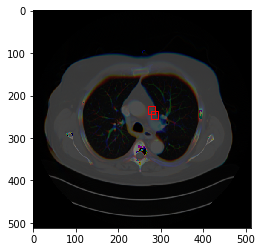

(512, 512, 3)


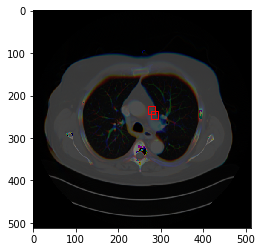

(512, 512, 3)
[[269.885 223.677 286.907 242.495]
 [276.496 236.196 294.309 255.654]]


In [299]:
train_dataset[28]
# train_dataset[54]
# for i in range(0, len(train_dataset)):
#     train_dataset[i]
    


In [137]:
for i in range(0, len(validation_dataset)):
    validation_dataset[i]

Length is 2
idx is 56
Length is 2
idx is 57
Length is 2
idx is 110
Length is 2
idx is 111
Length is 2
idx is 142
Length is 2
idx is 143
Length is 2
idx is 357
Length is 2
idx is 358
Length is 2
idx is 369
Length is 2
idx is 370
Length is 2
idx is 470
Length is 2
idx is 471
Length is 2
idx is 562
Length is 2
idx is 563
Length is 2
idx is 584
Length is 2
idx is 585
Length is 2
idx is 591
Length is 2
idx is 592
Length is 2
idx is 747
Length is 2
idx is 748
Length is 2
idx is 794
Length is 2
idx is 795
Length is 2
idx is 957
Length is 2
idx is 958
Length is 2
idx is 982
Length is 2
idx is 983
Length is 2
idx is 990
Length is 2
idx is 991
Length is 2
idx is 1001
Length is 2
idx is 1002
Length is 2
idx is 1059
Length is 2
idx is 1060
Length is 2
idx is 1085
Length is 2
idx is 1086
Length is 2
idx is 1117
Length is 2
idx is 1118
Length is 2
idx is 1121
Length is 2
idx is 1122
Length is 2
idx is 1313
Length is 2
idx is 1314
Length is 2
idx is 1324
Length is 2
idx is 1325
Length is 2
idx is 134

KeyboardInterrupt: 

In [133]:
for i in range(0, len(test_dataset)):
    test_dataset[i]

idx is 6
Length is False
idx is 6
idx is 7
Length is False
idx is 7
Length is False
idx is 109
Length is False
idx is 110
Length is False
idx is 143
Length is False
idx is 144
Length is False
idx is 155
Length is False
idx is 156
Length is False
idx is 157
Length is False
idx is 158
Length is False
idx is 174
Length is False
idx is 175
Length is False
idx is 186
Length is False
idx is 187
Length is False
idx is 188
Length is False
idx is 189
Length is False
idx is 328
Length is False
idx is 329
Length is False
idx is 334
Length is False
idx is 335
Length is False
idx is 342
Length is False
idx is 343
Length is False
idx is 389
Length is False
idx is 390
Length is False
idx is 399
Length is False
idx is 400
Length is False
idx is 404
Length is False
idx is 405
Length is False
idx is 418
Length is False
idx is 419
Length is False
idx is 464
Length is False
idx is 465
Length is False
idx is 558
Length is False
idx is 559
Length is False
idx is 617
Length is False
idx is 618
Length is Fals

KeyboardInterrupt: 